# Team Members

- Harsh Mehta _(hdm564)_
- Dipali Pandey _(dp33957)_
- Rohitashwa Chakraborty _(rc47878)_


Things to work on:
- $\beta_D$ is 0
- $r_f$ is 0
- d/e ratio assumed const

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown as md, Latex, Math

import statsmodels.api as sm
from patsy import dmatrices
import yfinance as yf
from datetime import datetime

import wrds
connection = wrds.Connection()

%matplotlib inline
plt.style.use("bmh")

Loading library list...
Done


# Inputs

## Hard-coded Inputs

In [2]:
stocks = "NVDA".split()
start = pd.to_datetime("2015-01-01").date()
# end = pd.to_datetime("2020-01-01")
end = pd.to_datetime(datetime.now()).date()
period = "1mo"

## User Inputs

In [3]:
# stocks = str(input("Space separated Stock Ticker(s):")).upper().split()
# market = str(input("market Ticker: ")).upper()
# tbonds = str(input("tbonds Ticker: ")).upper()

# start = pd.to_datetime(input("Start Date: "))
# end = pd.to_datetime(input("End Date: "))

# period = str(input("Frequency:"))

## Selected Inputs

In [4]:
print("Selected stock tickers:", stocks)
# print("market Ticker: ",market)
# print("tbonds Ticker: ",tbonds)
print("Start Date: ",start)
print("End Date: ",end)
print("Frequency:", period)

Selected stock tickers: ['NVDA']
Start Date:  2015-01-01
End Date:  2021-11-08
Frequency: 1mo


# Security Class

In [7]:
class Security():

    @classmethod
    def __init__(self, *args, **kwargs)-> None:
        if "market" in kwargs.keys():
            self._market = kwargs["market"]
            try:
                self._market_permno = self.__get_permno(self, kwargs["market"])
            except:
                raise Exception("Invalid Initialisation. Need A Market Proxy")
        else:
            self._market = "SPY"
            self._market_permno = 84398
        
        if "rf" in kwargs.keys():
            self._rf = kwargs["rf"]
            try:
                self._rf_permno = self.__get_permno(self, kwargs["rf"])
            except:
                raise Exception("Invalid Initialisation. Need A Risk Free Proxy")
        else:
            self._rf = "IRX"
            self._rf_permno = 1
        
        if "start_date" in kwargs.keys():
            self._start_date = kwargs['start_date']
        else:
            self._start_date = (pd.to_datetime(datetime.now()) - pd.DateOffset(years = 5)).date()
        
        if "end_date" in kwargs.keys():
            self._end_date = kwargs['end_date']
        else:
            self._end_date = pd.to_datetime(datetime.now()).date()
        
        
        
        if isinstance(args[0], str):
            self.ticker = args[0]
            try:
                md("......Fetching Company Info......")
                self.__get_company_info(self)
            except:
                md("–––––––––Failed to Fetch Ticker Information–––––––––")
                print(sys.exc_info()[1])
            
            try:
                md("......Fetching Comps Info......")
                self.__get_comps_info(self)
            except:
                md("–––––––––Failed to Fetch Comps Information–––––––––")
                print(sys.exc_info()[1])

        # elif isinstance(args[0], pd.Series):
        #     print(args[0].columns)
        #     self.permno, self.gvkey, self.ticker, self.name, self.public_date, self.mrktcap, self.efftax,\
        #         self.de_ratio, self.sic, self.spcsrc, self.ggroup, self.gind, self.gsector, self.gsubind = args[0]
        
        try:
            md("......Calculating Beta......")
            self.beta = self.__getbeta(self, self.ticker, self.permno)
        except:
            md("–––––––––Failed to Calculate Beta–––––––––")
            print(sys.exc_info()[1])
        return
    
    @staticmethod 
    def __get_permno(self, ticker)->float:
        sql_string = """
                    SELECT permno, conm
                    FROM comp.company c
                    INNER JOIN (
                            SELECT DISTINCT permno, gvkey
                            FROM wrdsapps_finratio.firm_ratio
                            WHERE ticker = '{tic}'
                        ) x ON x.gvkey = c.gvkey
                    """.format(tic = ticker)
        data =  connection.raw_sql(sql_string)
        return data['permno'][0]


    @staticmethod
    def __get_company_info(self)->None:
        sql_string = """
                        SELECT DISTINCT 
                            company.conm, ratio.*, company.sic, company.spcsrc, 
                            company.ggroup, company.gind, company.gsector, company.gsubind
                        FROM comp.company AS company
                        INNER JOIN (
                            SELECT permno, gvkey, mktcap, public_date, efftax, de_ratio, roe, int_debt as rod, roa 
                            FROM wrdsapps_finratio.firm_ratio
                            WHERE ticker = '{tic}'
                                AND public_date = (
                                    SELECT max(public_date)
                                    FROM wrdsapps_finratio.firm_ratio
                                )
                        ) ratio ON ratio.gvkey = company.gvkey
                        FETCH FIRST 10 ROWS ONLY""".format(tic = self.ticker)
        identifier = connection.raw_sql(sql_string)
        
        self.name, self.permno, self.gvkey, self.mrktcap, self.public_date,\
            self.efftax, self.de_ratio, self.roe, self.rod, self.roa,\
            self.sic, self.spcsrc, self.ggroup, self.gind, self.gsector, self.gsubind = identifier.values[0]

        self.efftax = float(self.efftax)
        self.public_date = pd.to_datetime(self.public_date)
        self.mrktcap = float(self.mrktcap)
        self.de_ratio = float(self.de_ratio)
        self.efftax
        self.roe
        self.rod
        self.roa

        self.sic = int(self.sic)
        self.gsector = int(self.gsector)
        self.ggroup = int(self.ggroup)
        self.gind = int(self.gind)
        self.gsubind = int(self.gsubind)
        return identifier

    @staticmethod
    def __get_comps_info(self)->None:
        sql_string = """
                        SELECT 
                            date.permno, date.gvkey, date.ticker, company.conm, date.public_date, 
                            date.mktcap, date.efftax, date.de_ratio, date.roe, date.rod, date.roa,
                            company.sic, company.spcsrc, company.gsector, company.ggroup, company.gind, company.gsubind
                        FROM (
                            SELECT DISTINCT conm, gvkey,
                            sic, spcsrc, ggroup, gind, gsector, gsubind,
                            ABS(CAST(gsector AS INT) - {gsector}) gsector_diff,
                            ABS(CAST(ggroup AS INT) - {ggroup}) ggroup_diff
                            FROM comp.company
                            WHERE sic = {sics}
                                AND ggroup  = {ggroup}
                                AND gvkey <> {gvkey}
                                AND spcsrc IS NOT NULL
                        ) company
                        INNER JOIN ( 
                            SELECT 
                                r.permno, r.ticker, r.gvkey, r.public_date, r.mktcap, ABS(CAST(r.mktcap AS INT) - {mktcap}) as market_cap_difference,
                                r.efftax, r.de_ratio, r.roa, r.roe, r.int_debt as rod
                            FROM wrdsapps_finratio.firm_ratio r
                            INNER JOIN (
                                SELECT gvkey, max(public_date) as public_date
                                FROM wrdsapps_finratio.firm_ratio
                                GROUP BY gvkey
                            ) x ON x.gvkey = r.gvkey AND x.public_date = r.public_date
                            ORDER BY market_cap_difference ASC
                        ) date ON date.gvkey = company.gvkey
                        WHERE company.gvkey <> {gvkey}
                        ORDER BY date.market_cap_difference ASC, spcsrc ASC, gsector DESC, ggroup DESC, gsector_diff DESC, ggroup_diff DESC, date.public_date DESC
                        FETCH FIRST 5 ROWS ONLY""".format(sics = "'"+str(self.sic)+"'",
                                                            gsector = "'"+str(self.gsector)+"'",
                                                            ggroup =  "'"+str(self.ggroup)+"'",
                                                            gind =  "'"+str(self.gind)+"'",
                                                            gsubind =  self.gsubind,
                                                            gvkey = "'"+str(self.gvkey)+"'",
                                                            mktcap = self.mrktcap
                                                        )
        self.comps = connection.raw_sql(sql_string)
        return

    @staticmethod
    def __get_data(self, ticker, permno)->pd.DataFrame:
        sql_string = """
                        SELECT 
                            date, ret AS {tic}
                        FROM crsp.dsf 
                        WHERE permno = {permno}
                            AND date >= '{start_date}'
                            AND date <= '{end_date}'""".format(
                                                            tic = ticker.upper(),
                                                            permno = permno,
                                                            start_date = self._start_date,
                                                            end_date = self._end_date
                                                        )
        ret_data = connection.raw_sql(sql_string).set_index('date').sort_index(ascending = True)
        return ret_data

    @staticmethod
    def __getbeta(self, ticker, permno, show_plot = False)->float:
        daily_ret = pd.DataFrame(columns=[ticker, self._market, self._rf])
        daily_ret[ticker] = self.__get_data(self, ticker, permno)
        daily_ret[self._market] = self.__get_data(self, self._market,self._market_permno)
        daily_ret[self._rf] = self.__get_data(self, self._rf,self._rf_permno)
        daily_ret.fillna(0.0, inplace = True)
        
        ## Calculate risk premimum
        daily_ret = daily_ret.apply(lambda row: (row[:-1]-(row[self._rf])), axis = 1)
        # data = data.apply(lambda row: (row[:-1]-(row[tbonds]/100)), axis = 1) # Converting bips to %age
        self.debug = daily_ret
        ## Regress OLS, implement CAPM
        formula = ticker + ' ~ '+ self._market
        md("\t"+formula)
        y, X = dmatrices(formula, data=daily_ret, return_type= "dataframe")
        model = sm.OLS(y, X)
        result = model.fit()
        # print(result.summary(),end="\n––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––\n\n")
        
        if show_plot:
            self.__plot_graph(self, ticker, X, y, result.params)
        return result.params[self._market]

    @staticmethod
    def __plot_graph(self, ticker, X, y, params)->None:
        '''
            Function to print the plots
        '''
        try:
            plt.figure(figsize=(10,7))
            plt.scatter(X[self._market], y, label = ticker)
            plt.legend()
            plt.xlabel("Systemic Risk")
            plt.ylabel("Risk Premium")
            plt.title("Security Characteristics Line Regression: "+ticker+" (β: "+str(round(params[self._market], 2))+")")
            plt.axhline(y=0, color='k', linewidth = 0.7)
            plt.axvline(x=0, color='k', linewidth = 0.7)

            f_x = np.dot(X,np.asarray(params))
            plt.plot(X[self._market],f_x, color = "red", linestyle = "dashed", linewidth = 0.7)
        except:
            print(sys.exc_info())
            raise Exception
        return

    def __unlever_beta(de: float, beta_levered: float, tax: float)-> float:
        ## ASK USER FOR TYPE OF UNLEVER TO USE
        case = "const"
        if case == "const":
            beta_unlevered = beta_levered/(1 + (1-tax)*de)
        return beta_unlevered

    @classmethod
    def get_comps_beta(self, verbose = False):

        md(r'**Step 1:** Calculating $\beta^{Comps}_{Levered}$')
        self.comps["beta_levered"] = self.comps[["ticker", "permno"]]\
                                        .apply(lambda row: (self.__getbeta(self,
                                                                            row["ticker"],
                                                                            row["permno"],
                                                                            show_plot = verbose
                                                                        )
                                                            ), axis = 1)

        
        md(r'**Step 2:** Unlever $\beta^{Comps}_{Levered}$; Calculating $\beta^{Comps}_{Unlevered}$')
        
        self.comps["beta_unlevered"] = self.comps[["de_ratio","beta_levered","efftax"]]\
                                            .apply(lambda row: (self.__unlever_beta(de = row["de_ratio"],
                                                                                beta_levered = row["beta_levered"],
                                                                                tax = row["efftax"]
                                                                            )
                                                                ), axis = 1)
        avg_beta_unlevered = self.comps["beta_unlevered"].mean()
        
        md(r'**Step 3:** $\beta^{Comps}_{Unevered} = \beta^{%s}_{Unevered} = %f | %f$'%(self.ticker, avg_beta_unlevered, self.beta))
        
        md(r'**Step 4:** Relever $\beta^{Comps}_{Unevered} = \beta^{%s}_{Unevered} = %f | %f$'%(self.ticker, avg_beta_unlevered, self.beta))

        pass

    @classmethod
    def echo(self)-> None:
        print("\nMarket Ticker:", self._market)
        print("Market Permno:", self._market_permno)
        
        print("\nRisk Ticker:", self._rf)
        print("Risk Free Rate Permno:", self._rf_permno)

        print("\nCompany Name:", self.name)
        print("Ticker:", self.ticker)
        print("Company PermNo:", self.permno)
        print("Company GV-Key: ", self.gvkey)
        print("Market Cap: ", self.mrktcap)
        print("Public Date: ", self.public_date.strftime("%d-%m-%Y"))
        print("Credit Rating: ", self.spcsrc)

        print("\nSIC Code: ", self.sic)
        print("Sector Code: ", self.gsector)
        print("Group Code: ", self.ggroup)
        print("Industry Code: ", self.gind)
        print("Sector Sub Industry Code: ", self.gsubind)
        
        print("\nD/E Ratio:", self.de_ratio)
        print("Effective Tax Rate: ", self.efftax)
        print("Cost of Equity: ", self.roe)
        print("Cost of Debt: ", self.rod)
        print("Cost of Capital: ", self.roa)
        print("Beta: ", self.beta)
        print("Comps:")
        return self.comps

# Initialising Securities

In [8]:
# security = [Security(stk, start_date = start, end_date = end) for stk in stocks][0]
security = Security(stocks[0], start_date = start, end_date = end)
security.echo()
security.comps


Market Ticker: SPY
Market Permno: 84398

Risk Ticker: IRX
Risk Free Rate Permno: 1

Company Name: NVIDIA CORP
Ticker: NVDA
Company PermNo: 86580.0
Company GV-Key:  117768
Market Cap:  323241.80755615234
Public Date:  31-12-2020
Credit Rating:  B+

SIC Code:  3674
Sector Code:  45
Group Code:  4530
Industry Code:  453010
Sector Sub Industry Code:  45301020

D/E Ratio: 0.6980440321900607
Effective Tax Rate:  0.05858585858585859
Cost of Equity:  0.3013132247839184
Cost of Debt:  0.02383316782522344
Cost of Capital:  0.2529702424012065
Beta:  1.5024333162009205
Comps:


,permno,gvkey,ticker,conm,public_date,mktcap,efftax,de_ratio,roe,rod,roa,sic,spcsrc,gsector,ggroup,gind,gsubind
0,59328.0,006008,INTC,INTEL CORP,2020-12-31,204162.358749,0.125114,0.874041,0.275543,0.028178,0.259725,3674,A-,45,4530,453010,45301020
1,93002.0,180711,AVGO,BROADCOM INC,2020-12-31,178204.952484,-0.212034,1.882557,0.136329,0.045441,0.160822,3674,B,45,4530,453010,45301020
2,77178.0,024800,QCOM,QUALCOMM INC,2020-12-31,172296.535858,0.091100,4.857166,0.932795,0.038507,0.169859,3674,B,45,4530,453010,45301020
3,15579.0,010499,TXN,TEXAS INSTRUMENTS INC,2020-12-31,150661.824942,0.124127,1.175805,0.593896,0.031758,0.359241,3674,A+,45,4530,453010,45301020
4,61241.0,001161,AMD,ADVANCED MICRO DEVICES,2020-12-31,110300.716419,0.083333,0.955968,0.309616,0.084337,0.241571,3674,B-,45,4530,453010,45301020


# Compute Cost of Capital

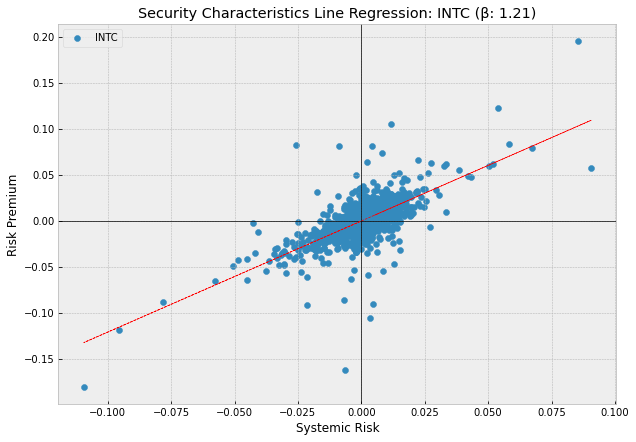

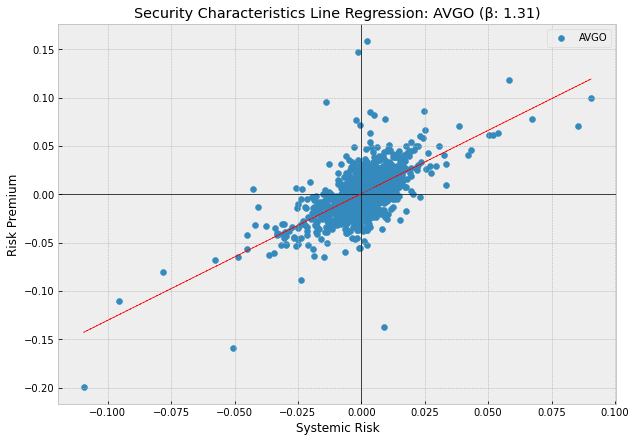

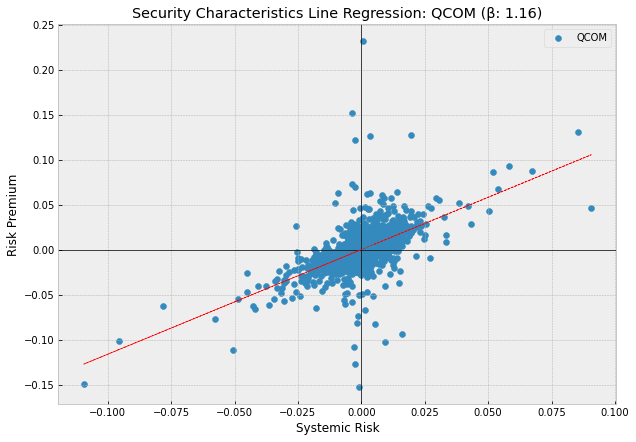

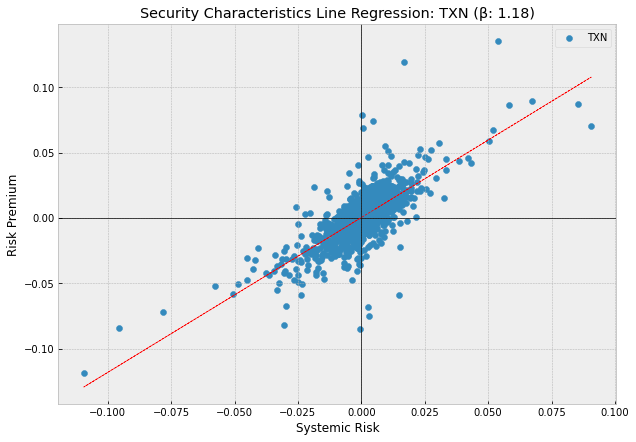

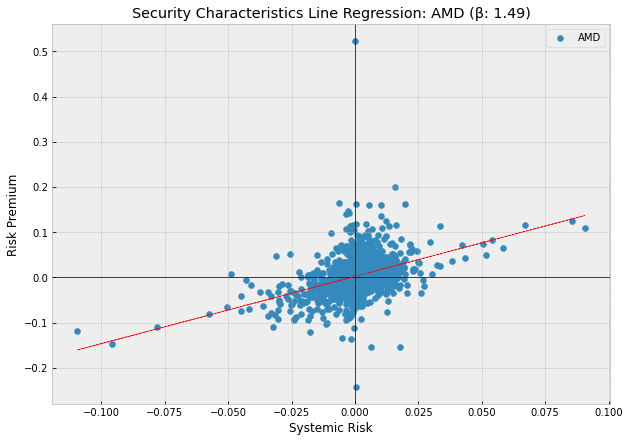

In [10]:
security.get_comps_beta(verbose = True)

In [11]:
security.comps

,permno,gvkey,ticker,conm,public_date,mktcap,efftax,de_ratio,roe,rod,roa,sic,spcsrc,gsector,ggroup,gind,gsubind,beta_levered,beta_unlevered
0,59328.0,006008,INTC,INTEL CORP,2020-12-31,204162.358749,0.125114,0.874041,0.275543,0.028178,0.259725,3674,A-,45,4530,453010,45301020,1.206661,0.683782
1,93002.0,180711,AVGO,BROADCOM INC,2020-12-31,178204.952484,-0.212034,1.882557,0.136329,0.045441,0.160822,3674,B,45,4530,453010,45301020,1.308294,0.398661
2,77178.0,024800,QCOM,QUALCOMM INC,2020-12-31,172296.535858,0.091100,4.857166,0.932795,0.038507,0.169859,3674,B,45,4530,453010,45301020,1.163022,0.214791
3,15579.0,010499,TXN,TEXAS INSTRUMENTS INC,2020-12-31,150661.824942,0.124127,1.175805,0.593896,0.031758,0.359241,3674,A+,45,4530,453010,45301020,1.184344,0.583462
4,61241.0,001161,AMD,ADVANCED MICRO DEVICES,2020-12-31,110300.716419,0.083333,0.955968,0.309616,0.084337,0.241571,3674,B-,45,4530,453010,45301020,1.486705,0.792358


In [ ]:

connection.raw_sql("")

,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,openprc,numtrd,retx
0,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-07,2.375,2.7500,-2.56250,1000.0,NaN,None,None,3680.0,1.0,1.0,None,None,NaN
1,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-08,2.375,2.6250,-2.50000,12800.0,-0.024390,None,None,3680.0,1.0,1.0,None,None,-0.024390
2,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-09,2.375,2.6250,-2.50000,1400.0,0.000000,None,None,3680.0,1.0,1.0,None,None,0.000000
3,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-10,2.375,2.6250,-2.50000,8500.0,0.000000,None,None,3680.0,1.0,1.0,None,None,0.000000
4,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-13,2.500,2.7500,-2.62500,5450.0,0.050000,None,None,3680.0,1.0,1.0,None,None,0.050000
5,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-14,2.625,2.8750,-2.75000,2075.0,0.047619,None,None,3680.0,1.0,1.0,None,None,0.047619
6,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-15,2.750,3.0000,-2.87500,22490.0,0.045455,None,None,3680.0,1.0,1.0,None,None,0.045455
7,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-16,2.875,3.1250,-3.00000,10900.0,0.043478,None,None,3680.0,1.0,1.0,None,None,0.043478
8,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-17,2.875,3.1250,-3.00000,8470.0,0.000000,None,None,3680.0,1.0,1.0,None,None,0.000000
9,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-20,2.875,3.1250,-3.00000,1000.0,0.000000,None,None,3680.0,1.0,1.0,None,None,0.000000


# Querying WRDS

## Query Comps

In [13]:
def get_company_info(tickers: list = None)->pd.DataFrame:
    ticlist = ", ".join(["'"+x+"'" for x in tickers])
    identifier = connection.raw_sql("""SELECT DISTINCT ratio.*, company.conm,
                        company.sic, company.spcsrc, company.ggroup, company.gind, company.gsector, company.gsubind
                        FROM comp.company AS company
                        INNER JOIN (
                            SELECT ticker, gvkey, mktcap, public_date
                            FROM wrdsapps_finratio.firm_ratio
                            WHERE ticker IN ({tic_list})
                                AND public_date = (
                                    SELECT max(public_date)
                                    FROM wrdsapps_finratio.firm_ratio
                                )
                        ) ratio ON ratio.gvkey = company.gvkey
                        FETCH FIRST 10 ROWS ONLY""".format(tic_list = ticlist))
    return identifier

def get_comps_info(sics: list = None)->pd.DataFrame:
    siclist = ", ".join(["'"+str(x)+"'" for x in sics])
    identifier = connection.raw_sql("""SELECT DISTINCT company.conm,
                        company.sic, company.spcsrc, company.ggroup, company.gind, company.gsector, company.gsubind
                        FROM comp.company AS company
                        WHERE sic IN ({sic_list})
                        FETCH FIRST 10 ROWS ONLY""".format(sic_list = siclist))
    return identifier

In [14]:
get_company_info(stocks)

,ticker,gvkey,mktcap,public_date,conm,sic,spcsrc,ggroup,gind,gsector,gsubind
0,AAPL,001690,2.255969e+06,2020-12-31,APPLE INC,3663,A-,4520,452020,45,45202030


In [52]:
get_comps_info([33663])
# siclist = ", ".join(["'"+x+"'" for x in trgt_identifier.sic])

# comps_identifier = connection.raw_sql("""SELECT DISTINCT company.conm,
#                     company.sic, company.spcsrc, company.ggroup, company.gind, company.gsector, company.gsubind
#                     FROM comp.company AS company
#                     WHERE sic IN ({sic_list})
#                     FETCH FIRST 10 ROWS ONLY""".format(sic_list = siclist))

# comps_identifier

,conm,sic,spcsrc,ggroup,gind,gsector,gsubind


In [36]:
connection.raw_sql("""SELECT *
                        FROM wrdsapps_finratio.firm_ratio
                    FETCH FIRST 10 ROWS ONLY""".format(tic_list = ticlist))#.columns.tolist()

,gvkey,permno,adate,qdate,public_date,capei,be,bm,evm,pe_op_basic,...,ffi30,ffi38_desc,ffi38,ffi48_desc,ffi48,ffi49_desc,ffi49,dt,ticker,cusip
0,001000,25881.0,1969-12-31,1970-09-30,1971-01-31,10.949959,10.211,0.427328,1.761483,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,3925.0,None,None
1,001000,25881.0,1970-12-31,1970-12-31,1971-02-28,35.407426,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4017.0,AE,00003210
2,001000,25881.0,1970-12-31,1970-12-31,1971-03-31,31.031228,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4017.0,AE,00003210
3,001000,25881.0,1970-12-31,1970-12-31,1971-04-30,34.213918,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4017.0,AE,00003210
4,001000,25881.0,1970-12-31,1971-03-31,1971-05-31,11.306738,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4107.0,AE,00003210
5,001000,25881.0,1970-12-31,1971-03-31,1971-06-30,10.815141,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4107.0,AE,00003210
6,001000,25881.0,1970-12-31,1971-03-31,1971-07-31,8.029423,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4107.0,AE,00003210
7,001000,25881.0,1970-12-31,1971-06-30,1971-08-31,7.369151,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4198.0,AE,00003210
8,001000,25881.0,1970-12-31,1971-06-30,1971-09-30,6.491872,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4198.0,AE,00003210
9,001000,25881.0,1970-12-31,1971-06-30,1971-10-31,6.842784,10.544,0.431071,7.009840,None,...,None,RUBBR,16.0,RUBBR,15.0,RUBBR,15.0,4198.0,AE,00003210


In [37]:
siclist = ", ".join(["'"+x+"'" for x in trgt_identifier.sic])

comps_identifier = connection.raw_sql("""SELECT DISTINCT ratio.*, company.conm,
                    company.sic, company.spcsrc, company.ggroup, company.gind, company.gsector, company.gsubind, company.mrktcap
                    FROM comp.company AS company
                    INNER JOIN (
                        SELECT DISTINCT ticker, gvkey
                        FROM wrdsapps_finratio.firm_ratio
                    ) ratio ON ratio.gvkey = company.gvkey
                    WHERE company.sic IN ({sic_list})
                    ORDER BY sic
                    FETCH FIRST 10 ROWS ONLY""".format(tic_list = ticlist, sic_list = siclist))

comps_identifier

ProgrammingError: (psycopg2.errors.UndefinedColumn) column company.mrktcap does not exist
LINE 2: ..., company.gind, company.gsector, company.gsubind, company.mr...
                                                             ^

[SQL: SELECT DISTINCT ratio.*, company.conm,
                    company.sic, company.spcsrc, company.ggroup, company.gind, company.gsector, company.gsubind, company.mrktcap
                    FROM comp.company AS company
                    INNER JOIN (
                        SELECT DISTINCT ticker, gvkey
                        FROM wrdsapps_finratio.firm_ratio
                    ) ratio ON ratio.gvkey = company.gvkey
                    WHERE company.sic IN ('3663')
                    ORDER BY sic
                    FETCH FIRST 10 ROWS ONLY]
(Background on this error at: https://sqlalche.me/e/14/f405)

## Fetch Relevant Data for Each Comp

In [ ]:
connection.raw_sql("""SELECT fr.ticker, gvkey, fr.public_date, efftax, de_ratio, roa, roe, int_debt as rod, gsector, gicdesc
                    FROM wrdsapps_finratio.firm_ratio fr
                    INNER JOIN (                                -- INNER JOIN SELECTS MAX
                        SELECT DISTINCT ticker, public_date, mktcap
                        FROM wrdsapps_finratio.firm_ratio
                        WHERE ticker IN ({tic_list})
                        ORDER BY public_date DESC, ticker
                    ) mfr ON fr.ticker = mfr.ticker AND fr.public_date = mfr.public_date
                    FETCH FIRST 10 ROWS ONLY""".format(tic_list = ", ".join(["'"+x+"'" for x in stocks])))#.columns.tolist())

,ticker,gvkey,public_date,efftax,de_ratio,roa,roe,rod,gsector,gicdesc
0,AAPL,001690,1981-02-28,0.515651,0.556366,0.850894,0.868376,1.137650,None,None
1,AAPL,001690,1981-03-31,0.515651,0.556366,0.850894,0.868376,1.137650,None,None
2,AAPL,001690,1981-04-30,0.515651,0.556366,0.850894,0.868376,1.137650,None,None
3,AAPL,001690,1981-05-31,0.515651,0.420460,0.605638,0.467510,1.214564,None,None
4,AAPL,001690,1981-06-30,0.515651,0.420460,0.605638,0.467510,1.214564,None,None
5,AAPL,001690,1981-07-31,0.515651,0.420460,0.605638,0.467510,1.214564,None,None
6,AAPL,001690,1981-08-31,0.515651,0.368483,0.538757,0.387905,1.049765,None,None
7,AAPL,001690,1981-09-30,0.515651,0.368483,0.538757,0.387905,1.049765,None,None
8,AAPL,001690,1981-10-31,0.515651,0.368483,0.538757,0.387905,1.049765,None,None
9,AAPL,001690,1981-11-30,0.484995,0.436622,0.466807,0.376237,1.008143,None,None
